In [2]:
import openmc
import openmc.mgxs as mgxs
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(1, '../../../scripts')
from knp_analysis import * 
sys.path.insert(1, '../../../../../fhr-benchmark-1/scripts')
import openmc_analysis as oa

In [3]:
sp = openmc.StatePoint('./plank_10_slice_refl/140pcm-tallies/statepoint.80.h5')
sp_mg = openmc.StatePoint('./plank_10_slice_mg_refl/98pcm-tallies/statepoint.80.h5')
df_moltres = pd.read_csv('./moltres_plank_10_slice_refl/delayed/fhr_plank_criticality_search_csv.csv')

In [3]:
# KEFF

In [4]:
sp_keff = sp.k_combined.n
sp_mg_keff = sp_mg.k_combined.n
moltres_keff = 1.406954 # taken from moltres_plank_10_slice_refl/delayed/cli_result

In [5]:
def reactivity(keff):
    return (keff-1)/keff

In [6]:
pd_keff = {"openmc no hom": sp_keff, "openmc hom": sp_mg_keff, "moltres": moltres_keff}
pd_diff = {"openmc no hom": 0, "openmc hom": (sp_mg_keff-sp_keff)*1e5, "moltres": (moltres_keff-sp_keff)*1e5}
reactivity_val = {"openmc no hom": reactivity(sp_keff)*1e5, "openmc hom": reactivity(sp_mg_keff)*1e5, "moltres": reactivity(moltres_keff)*1e5}
reactivity_err = {"openmc no hom": sp.k_combined.s/sp_keff**2*1e5, "openmc hom": sp_mg.k_combined.s/sp_mg_keff**2*1e5, "moltres": 0}
pf_norm_diff = {"openmc no hom": 0, "openmc hom": (sp_mg_keff-sp_keff)/sp_keff*1e5, "moltres": (moltres_keff-sp_keff)/sp_keff*1e5}
reactivity_diff = {"openmc no hom": 0, "openmc hom": (reactivity(sp_mg_keff)-reactivity(sp_keff))*1e5, "moltres": (reactivity(moltres_keff)-reactivity(sp_keff))*1e5}
data = [pd_keff, pd_diff, pf_norm_diff, reactivity_val, reactivity_err, reactivity_diff]
df_keff_results = pd.DataFrame(data, index =['keff', 'keff diff [pcm]', 'keff norm diff', 'reactivity [pcm]', 'reactivity_err', 'reactivity diff [pcm]'])


In [7]:
df_keff_results = df_keff_results.transpose()
df_keff_results

,keff,keff diff [pcm],keff norm diff,reactivity [pcm],reactivity_err,reactivity diff [pcm]
openmc no hom,1.414018,0.000000,0.000000,29279.554957,69.795906,0.000000
openmc hom,1.414726,70.808849,50.076333,29314.951437,49.056590,35.396480
moltres,1.406954,-706.425086,-499.586965,28924.470878,0.000000,-355.084079


In [8]:
140/1.41402**2

70.01916563201296

In [9]:
# BETA 

In [10]:
beta_openmc = get_beta(sp)*1e5
beta_openmc

654.3080999241787

In [11]:
df_no_delayed = pd.read_csv("./moltres_plank_10_slice_refl/nodelayed/fhr_plank_criticality_search_csv.csv")
keff_moltres_no_delayed = list(df_no_delayed["Executioner/eigenvalue"])[-1]
beta_moltres = (moltres_keff-keff_moltres_no_delayed)/moltres_keff*1e5
beta_moltres

654.2767209731078

In [12]:
pd_beta = {"openmc": round(beta_openmc,2), "moltres": round(beta_moltres,2)}
pd_beta_diff = {"openmc": 0, "moltres":round(beta_moltres-beta_openmc,2)}
data = [pd_beta, pd_beta_diff]
df_beta = pd.DataFrame(data, index =['beta', 'beta diff'])

In [13]:
df_beta = df_beta.transpose()
df_beta

,beta,beta diff
openmc,654.31,0.00
moltres,654.28,-0.03


In [14]:
# TEMP COEFF 

In [15]:
sp_1100K = openmc.StatePoint('./1100K-4groups/plank_10_slice_refl/126pcm/statepoint.80.h5', autolink=False)
keff_openmc_1100K = sp_1100K.k_combined
tc_openmc = oa.reactivity_coefficient_b(sp_keff,sp.k_combined.s, keff_openmc_1100K.n, keff_openmc_1100K.s, (1100-948))
tc_openmc

(-4.259316092645603, 0.6243138737273672)

In [16]:
df_1100K = pd.read_csv("./1100K-4groups/moltres_plank_10_slice_refl/fhr_plank_criticality_search_csv.csv")
keff_moltres_1100 = list(df_1100K["Executioner/eigenvalue"])[-1]
tc_moltres = oa.reactivity_coefficient_b(moltres_keff,0 , keff_moltres_1100, 0, (1100-948))
tc_moltres

(-4.493640781871432, 0.0)

In [17]:
pd_tc =  {"openmc": round(tc_openmc[0],2), "moltres": round(tc_moltres[0],2)}
pd_tc_diff = {"openmc": 0, "moltres": round(tc_moltres[0]-tc_openmc[0],2)}
data = [pd_tc, pd_tc_diff]
df_tc = pd.DataFrame(data, index =['temp coeff', 'diff'])

In [18]:
df_tc = df_tc.transpose()
df_tc

,temp coeff,diff
openmc,-4.26,0.00
moltres,-4.49,-0.23


In [19]:
# FLUX 

In [20]:
def get_values(sp_file):
    tally_flux = sp_file.get_tally(name='flux')
    flux = tally_flux.get_slice(scores=['flux'])
    nu_fission = tally_flux.get_slice(scores=['nu-fission'])
    fission = tally_flux.get_slice(scores=['fission'])
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    egs = [(1e-6, 1.8554), (1.8554, 2.9023e1), (2.9023e1, 9.1188e3), (9.1188e3, 2.0e7)]
    flux_eg, nu = {}, {}
    for x in range(4):
        print(x)
        flux_eg[x] = flux.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu_fiss_eg = nu_fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        fiss_eg = fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu[x] = sum(nu_fiss_eg.mean) / sum(fiss_eg.mean)
    return flux_eg, nu

In [21]:
flux_eg, nu = get_values(sp)

0
1
2
3


In [22]:
df_flux = pd.read_csv("./moltres_plank_10_slice_refl/delayed/fhr_plank_criticality_search_csv_flux_centerline_0002.csv")

In [23]:
def get_flux_dict_plank(k, P, z_thickness):
    Q = 200 * 1.6022e-13
    V = 27.1 * 3.25 * z_thickness / (100 * 20)
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    for x in range(4):
        N = P * nu[x] / (Q * k)
        flux_conv_dict[eg_names[x]] = flux_eg[x].mean * 1 / V * N
        flux_conv_dict[eg_names[x]].shape = (20, 100)
        flux_conv_dict[eg_names[x]][np.isnan(flux_conv_dict[eg_names[x]])] = 0
    return flux_conv_dict

In [24]:
power_moltres = 1456 # 1cm thick
flux_vals_openmc = get_flux_dict_plank(sp_keff, power_moltres, z_thickness=1)

In [25]:
def plot_flux_comparisons(group, flux_vals, df, name):
    moltres = np.array(list(df["group"+str(group)]))*power_moltres/210353
    openmc = np.array(flux_vals['eg'+str(group)][10])
    perc_diff = list((moltres-openmc) /openmc * 100)
    abs_perc_diff = list(abs(np.array(perc_diff)))
    max_val = max(abs_perc_diff)
    max_index = abs_perc_diff.index(max_val)
    print(perc_diff[max_index], max_index)
    norm_2 = np.linalg.norm(np.array(perc_diff))/len(moltres)
    print(norm_2)
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(list(df['x']), flux_vals['eg'+str(group)][10], label='openmc TRISO fidelity')
    ax.plot(list(df['x']) , np.array(list(df['group'+str(group)]))*power_moltres/210353, label='moltres spatially homogenized')
    handles, labels = ax.get_legend_handles_labels()
    if group == 4:
        y = 0.3
    else:
        y = 1
    ax.legend(handles, labels, bbox_to_anchor=(1, y), fontsize=14)
    ax.set_xlabel('x [cm]', fontsize=18)
    ax.set_ylabel(r'Flux [$n \cdot cm^{-2}s^{-1}$]', fontsize=18)
    ax.set_ylim(0, 1.75e14)
    ax.set_xlim(0, 27.1)
    ax.set_yticks([0, 0.5*1e14, 1.0*1e14, 1.5*1e14])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title('Group '+str(group), fontsize=18)
    ax.grid()
    plt.savefig(name)

-4.9094296733421725 9
0.2816289628075146


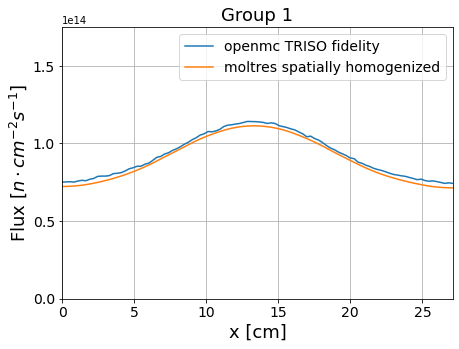

In [26]:
plot_flux_comparisons(1, flux_vals_openmc, df_flux, 'flux_group1_948K')

5.174299879013208 45
0.39463972892933474


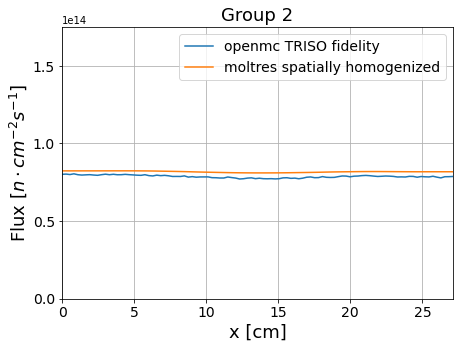

In [27]:
plot_flux_comparisons(2, flux_vals_openmc, df_flux, 'flux_group2_948K')

6.820331482837318 57
0.40030284864657373


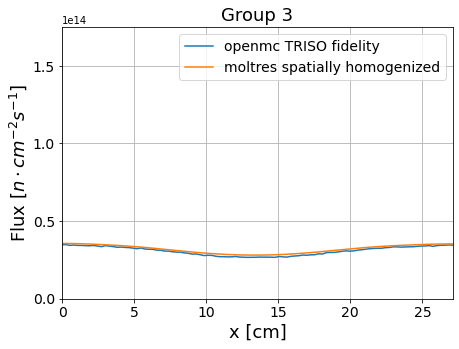

In [28]:
plot_flux_comparisons(3, flux_vals_openmc, df_flux, 'flux_group3_948K')

5.228784864895505 54
0.2784116556337336


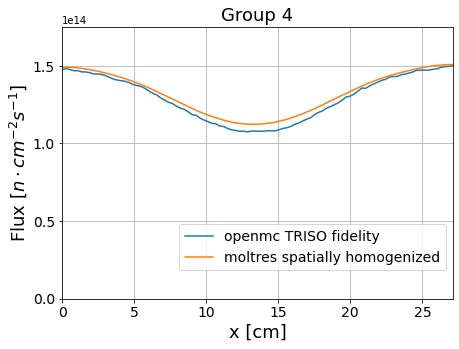

In [29]:
plot_flux_comparisons(4, flux_vals_openmc, df_flux, 'flux_group4_948K')

In [30]:
# FLUX SPECTRUM 

In [33]:
bins, engs = generate_bins()

In [34]:
spectrum_252 = get_252_spectrum(sp, sp_keff, power_moltres)
spectrum_4 = get_4_spectrum(sp, sp_keff, power_moltres)
groups_4 = [1e-6, 1.8554, 2.9023e1, 9.1188e3, 2.0e7]

In [35]:
moltres_spectrum = np.array([1.912978e+16, 4.626687e+15, 1.181716e+16, 1.302617e+16])*power_moltres/210353 / bins
moltres = np.append(moltres_spectrum[0], moltres_spectrum)
# taken from moltres_plank_10_slice_refl/delayed/cli_result


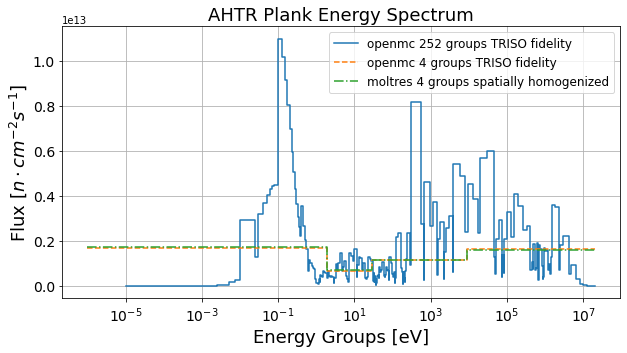

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
ax.semilogx(np.array(engs) , spectrum_252, drawstyle='steps', label='openmc 252 groups TRISO fidelity')
#ax.semilogx(groups_4 , spectrum_4_mg, drawstyle='steps', label='openmc 4 groups spatially homogenized')
ax.semilogx(groups_4 , spectrum_4, '--', drawstyle='steps', label='openmc 4 groups TRISO fidelity')
ax.semilogx(groups_4 , moltres, '-.', drawstyle='steps', label='moltres 4 groups spatially homogenized')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1, 1), fontsize=12)
ax.set_xlabel('Energy Groups [eV]', fontsize=18)
ax.set_ylabel(r'Flux [$n \cdot cm^{-2}s^{-1}$]', fontsize=18)
ax.set_title('AHTR Plank Energy Spectrum', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()
plt.savefig('neutron_spectrum_948K', dpi=300)